In [1]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [2]:
from utils import base_configs, deps, tr_va_te_split
from utils.helpers import rw_csv_helpers

In [3]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
CONFIGS = base_configs.get_base_configs()
# path to your global SHAP file

#SWITCH THE FOLLOWING ACCORDINGLY
CONFIGS["RUN_TS"] = "20251118_101434"

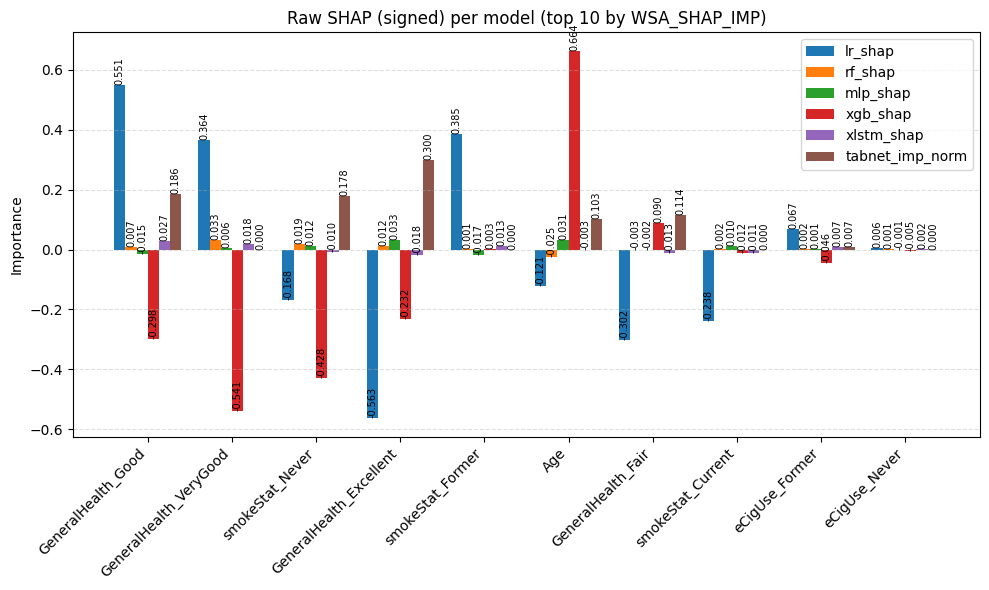

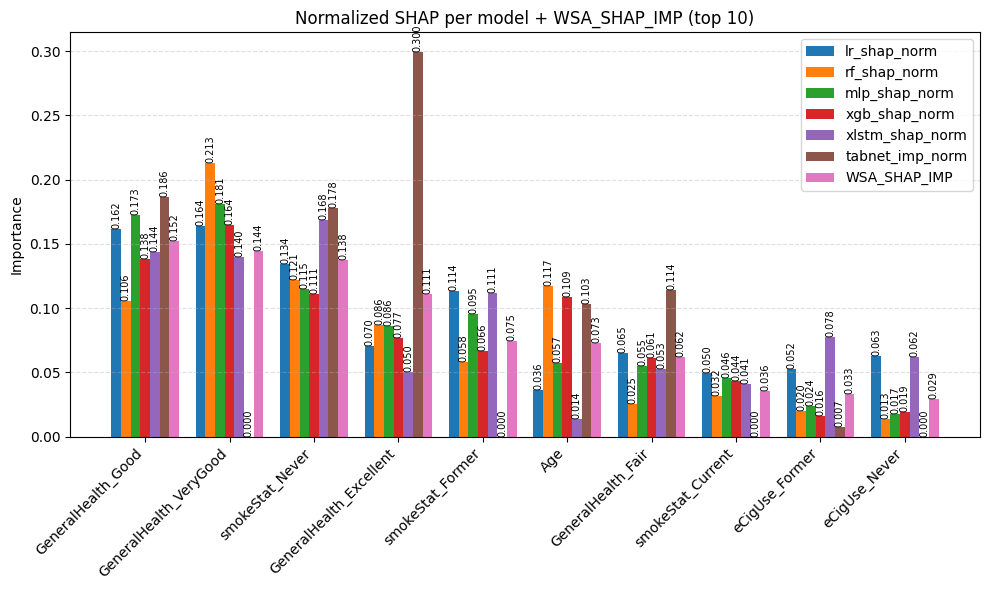

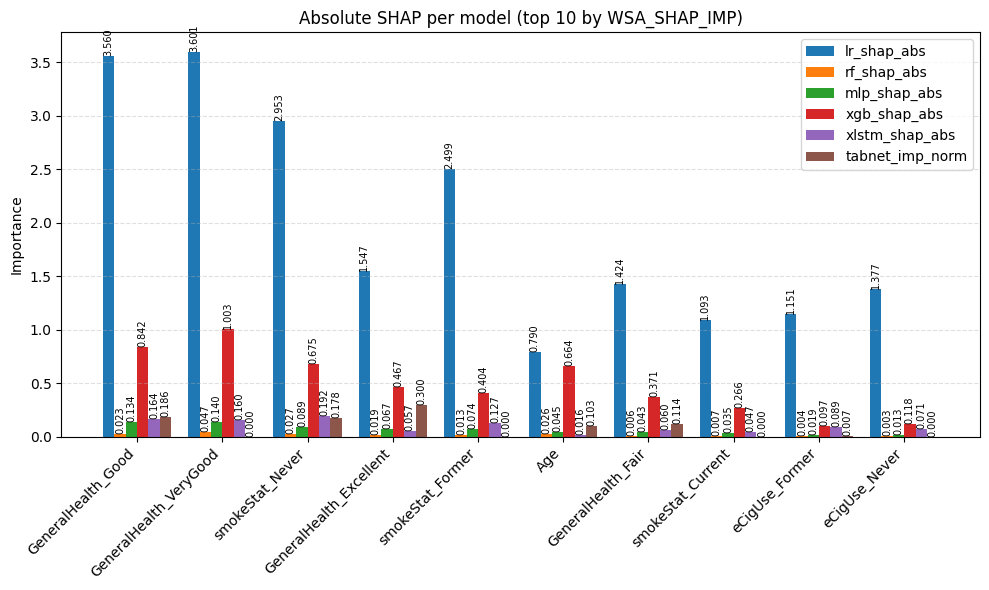

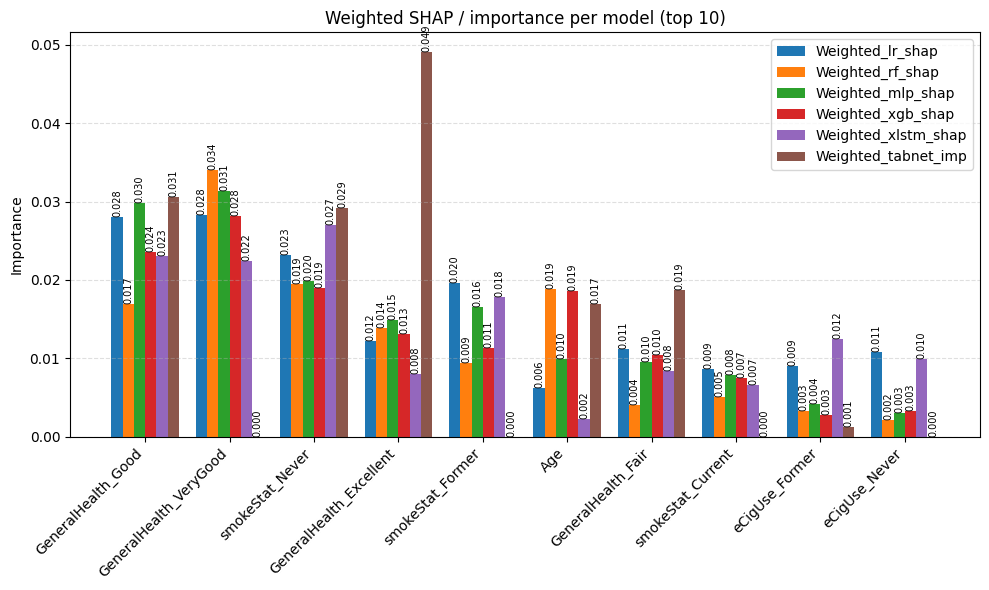

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Read the global shap file
# ------------------------------------------------------------------
# CHANGE THIS PATH to your actual file location
path = f"op/tr_va_te_metric_shap_{CONFIGS['RUN_TS']}/global_shap_{CONFIGS['RUN_TS']}_with_weightedSHAP_InclTabNetImp_WSA.csv"
# if your file has .xls extension but is actually CSV, this still works:
df = pd.read_csv(path)

# ------------------------------------------------------------------
# 2. Helper: grouped bar plot with value labels
# ------------------------------------------------------------------
def grouped_bar_plot(df_sub, cols, title, ylabel="Importance"):
    n_feats = df_sub.shape[0]
    n_cols = len(cols)
    x = np.arange(n_feats)
    width = 0.8 / n_cols          # total group width = 0.8

    fig, ax = plt.subplots(
        figsize=(max(10, n_feats * 0.7), 6)
    )

    for i, col in enumerate(cols):
        values = df_sub[col].values
        # shift bars within each group
        bars = ax.bar(
            x + (i - (n_cols - 1) / 2) * width,
            values,
            width,
            label=col
        )

        # add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=7,
                rotation=90,
            )

    ax.set_xticks(x)
    ax.set_xticklabels(df_sub["feature"], rotation=45, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 3. Choose features: top N by WSA_SHAP_IMP
# ------------------------------------------------------------------
top_n = 10
df_top = df.sort_values("WSA_SHAP_IMP", ascending=False).head(top_n)

# ------------------------------------------------------------------
# 4. Plots
# ------------------------------------------------------------------

# 1) First plot: raw SHAP (signed) per model + TabNet importance
cols_1 = [
    "lr_shap",
    "rf_shap",
    "mlp_shap",
    "xgb_shap",
    "xlstm_shap",
    "tabnet_imp_norm",
]
grouped_bar_plot(
    df_top,
    cols_1,
    "Raw SHAP (signed) per model (top 10 by WSA_SHAP_IMP)"
)

# 2) Second plot: normalized SHAP per model + WSA_SHAP_IMP
cols_2 = [
    "lr_shap_norm",
    "rf_shap_norm",
    "mlp_shap_norm",
    "xgb_shap_norm",
    "xlstm_shap_norm",
    "tabnet_imp_norm",
    "WSA_SHAP_IMP",
]
grouped_bar_plot(
    df_top,
    cols_2,
    "Normalized SHAP per model + WSA_SHAP_IMP (top 10)"
)

# 3) Third plot: absolute SHAP per model + TabNet importance
cols_3 = [
    "lr_shap_abs",
    "rf_shap_abs",
    "mlp_shap_abs",
    "xgb_shap_abs",
    "xlstm_shap_abs",
    "tabnet_imp_norm",
]
grouped_bar_plot(
    df_top,
    cols_3,
    "Absolute SHAP per model (top 10 by WSA_SHAP_IMP)"
)

# 4) Fourth plot: weighted importances per model
cols_4 = [
    "Weighted_lr_shap",
    "Weighted_rf_shap",
    "Weighted_mlp_shap",
    "Weighted_xgb_shap",
    "Weighted_xlstm_shap",
    "Weighted_tabnet_imp",
]
grouped_bar_plot(
    df_top,
    cols_4,
    "Weighted SHAP / importance per model (top 10)"
)


In [6]:
## RANKING EACH FEATURES OF EACH MODEL ##

In [7]:
import os
import pandas as pd

# Model ids and human-readable names
model_info = {
    "lr": "Logistic Regression",
    "rf": "Random Forest",
    "mlp": "Multi Layer Perceptron",
    "tabnet": "TabNet",
    "xgb": "XGBoost",
    "xlstm": "XLSTM",
}

run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"

# ---------- 1. Read global SHAP file ----------
global_path = os.path.join(base_dir, f"global_shap_{run_ts}.csv")
global_df = pd.read_csv(global_path)

if "feature" in global_df.columns:
    global_df = global_df.set_index("feature")

# ---------- 2. Read model strengths / weights ----------
strength_path = os.path.join(base_dir, "models_pred_strength.csv")
strength_df = pd.read_csv(strength_path).set_index("ModelName")  # lr, rf, ...

# ---------- 3. For each SHAP model, create Weighted_{key}_shap ----------
# TabNet SHAP is not in the global_shap file, so exclude it from this loop
shap_models = [k for k in model_info.keys() if k != "tabnet"]

for key in shap_models:
    shap_norm_col = f"{key}_shap_norm"

    if shap_norm_col not in global_df.columns:
        print(f"[WARN] Column {shap_norm_col} not found in global_shap file; skipping {key}")
        continue

    if key not in strength_df.index:
        print(f"[WARN] Model {key} not found in models_pred_strength; skipping")
        continue

    model_weight = strength_df.loc[key, "ModelWeight"]
    weighted_col = f"Weighted_{key}_shap"
    global_df[weighted_col] = global_df[shap_norm_col] * model_weight

# ---------- 4. Read TabNet feature importances and normalize ----------
tabnet_feat_path = os.path.join(base_dir, "tabnet", "tabnet_features.csv")

if os.path.exists(tabnet_feat_path):
    tabnet_df = pd.read_csv(tabnet_feat_path)[["feature", "importance"]].set_index("feature")

    den = tabnet_df["importance"].sum()
    if den != 0:
        tabnet_df["tabnet_imp_norm"] = tabnet_df["importance"] / den
    else:
        tabnet_df["tabnet_imp_norm"] = 0.0

    global_df = global_df.join(tabnet_df["tabnet_imp_norm"], how="left")

    # ---------- 5. Weighted_tabnet_imp = tabnet_imp_norm * ModelWeight(tabnet) ----------
    if "tabnet" in strength_df.index:
        tabnet_weight = strength_df.loc["tabnet", "ModelWeight"]
        global_df["Weighted_tabnet_imp"] = global_df["tabnet_imp_norm"] * tabnet_weight
    else:
        print("[WARN] TabNet not in models_pred_strength; cannot compute Weighted_tabnet_imp.")
else:
    print(f"[WARN] TabNet features file not found: {tabnet_feat_path}")

# ---------- 6. WSA_SHAP_IMP: combined weighted importance across 6 models ----------
wsa_cols = [
    "Weighted_lr_shap",
    "Weighted_rf_shap",
    "Weighted_mlp_shap",
    "Weighted_xgb_shap",
    "Weighted_xlstm_shap",
    "Weighted_tabnet_imp",
]

missing = [c for c in wsa_cols if c not in global_df.columns]
if missing:
    print(f"[WARN] Some weighted columns missing, cannot fully compute WSA_SHAP_IMP: {missing}")

present_cols = [c for c in wsa_cols if c in global_df.columns]
if present_cols:
    # Sum (not average): should sum to ~1 across all features
    global_df["WSA_SHAP_IMP"] = global_df[present_cols].sum(axis=1)
else:
    global_df["WSA_SHAP_IMP"] = float("nan")

# ---------- 7. Rank features for each model and for WSA_SHAP_IMP ----------
for key in shap_models:
    weighted_col = f"Weighted_{key}_shap"
    if weighted_col in global_df.columns:
        rank_col = f"Rank_{key}_shap"
        global_df[rank_col] = (
            global_df[weighted_col]
            .rank(ascending=False, method="dense")
            .astype(int)
        )

# Rank for TabNet weighted importance (if present)
if "Weighted_tabnet_imp" in global_df.columns:
    global_df["Rank_tabnet_imp"] = (
        global_df["Weighted_tabnet_imp"]
        .rank(ascending=False, method="dense")
        .astype(int)
    )

if "WSA_SHAP_IMP" in global_df.columns:
    global_df["Rank_WSA_SHAP_IMP"] = (
        global_df["WSA_SHAP_IMP"]
        .rank(ascending=False, method="dense")
        .astype(int)
    )

# ---------- 8. Sort by WSA_SHAP_IMP ----------
if "WSA_SHAP_IMP" in global_df.columns:
    global_df = global_df.sort_values("WSA_SHAP_IMP", ascending=False)

# ---------- 9. Save updated global_shap file ----------
global_out_path = os.path.join(
    base_dir,
    f"global_shap_{run_ts}_with_weightedSHAP_InclTabNetImp_WSA_ranked.csv",
)
global_df.to_csv(global_out_path)

print(
    "Saved updated global SHAP with Weighted_* columns, tabnet_imp_norm, "
    "Weighted_tabnet_imp, WSA_SHAP_IMP, and rank columns to:",
    global_out_path,
)


Saved updated global SHAP with Weighted_* columns, tabnet_imp_norm, Weighted_tabnet_imp, WSA_SHAP_IMP, and rank columns to: op/tr_va_te_metric_shap_20251118_101434/global_shap_20251118_101434_with_weightedSHAP_InclTabNetImp_WSA_ranked.csv


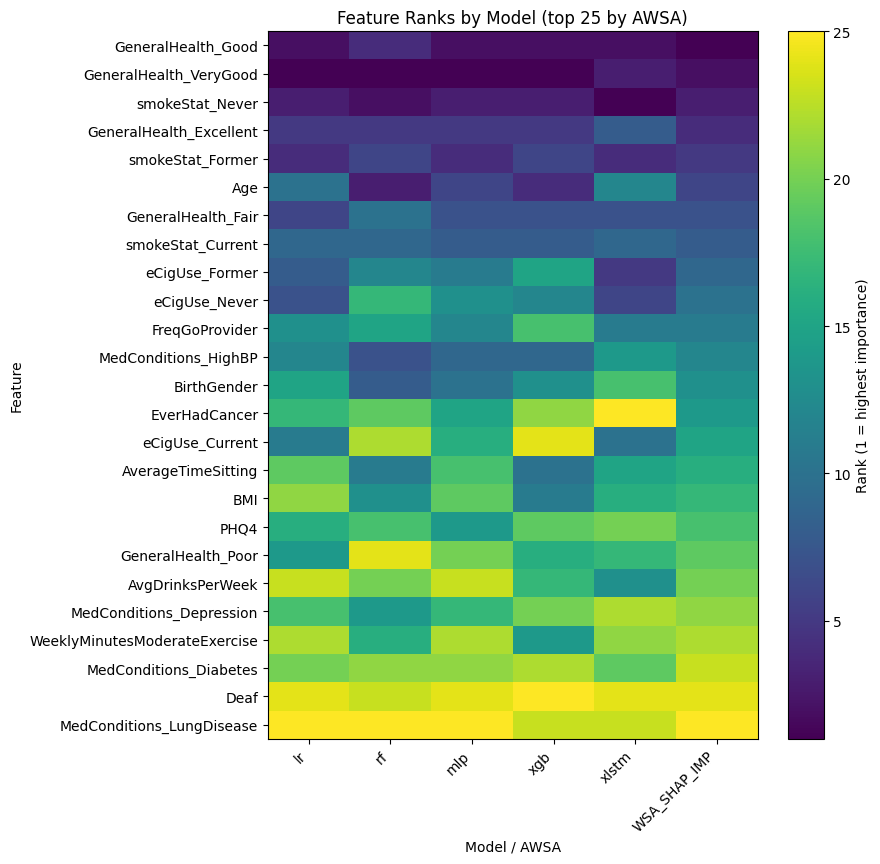

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- config ----------
run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"
global_path = os.path.join(
    base_dir,
    f"global_shap_{run_ts}_with_weightedSHAP_InclTabNetImp_WSA_ranked.csv"
)

# ---------- read data ----------
df = pd.read_csv(global_path)

# feature index
if "feature" in df.columns:
    df = df.set_index("feature")

# rank columns for each model + AWSA
rank_cols = [
    "Rank_lr_shap",
    "Rank_rf_shap",
    "Rank_mlp_shap",
    "Rank_tabnet_shap",
    "Rank_xgb_shap",
    "Rank_xlstm_shap",
    "Rank_WSA_SHAP_IMP",
]
rank_cols = [c for c in rank_cols if c in df.columns]  # keep only existing

# sort features by combined AWSA rank and take top N (e.g. 25)
N = 25
if "Rank_WSA_SHAP_IMP" in df.columns:
    df_plot = df.sort_values("Rank_WSA_SHAP_IMP").head(N)
else:
    # fallback: just take first N if AWSA rank not present
    df_plot = df.head(N)

# matrix of ranks: rows = features, cols = models
rank_matrix = df_plot[rank_cols].values
features = df_plot.index.to_list()
model_labels = [c.replace("Rank_", "").replace("_shap", "") for c in rank_cols]

# ---------- plot heatmap ----------
fig, ax = plt.subplots(figsize=(1.5 * len(rank_cols), 0.35 * len(features)))

im = ax.imshow(rank_matrix, aspect="auto")

# axes ticks
ax.set_xticks(np.arange(len(model_labels)))
ax.set_xticklabels(model_labels, rotation=45, ha="right")
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(features)

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Rank (1 = highest importance)")

ax.set_xlabel("Model / AWSA")
ax.set_ylabel("Feature")
ax.set_title(f"Feature Ranks by Model (top {N} by AWSA)")

plt.tight_layout()
plt.show()


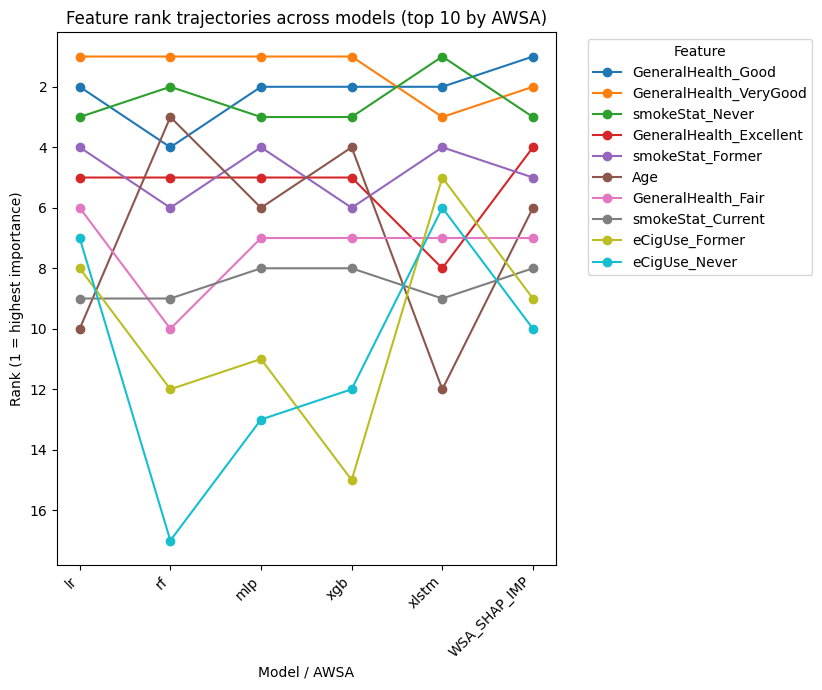

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

run_ts = CONFIGS["RUN_TS"]
base_dir = f"op/tr_va_te_metric_shap_{run_ts}"
global_path = os.path.join(
    base_dir,
    f"global_shap_{run_ts}_with_weightedSHAP_InclTabNetImp_WSA_ranked.csv"
)

# ---------- read data ----------
df = pd.read_csv(global_path)

# make 'feature' the index
if "feature" in df.columns:
    df = df.set_index("feature")

# rank columns in the order you want on the x-axis
rank_cols = [
    "Rank_lr_shap",
    "Rank_rf_shap",
    "Rank_mlp_shap",
    "Rank_tabnet_shap",
    "Rank_xgb_shap",
    "Rank_xlstm_shap",
    "Rank_WSA_SHAP_IMP",   # put AWSA at the end
]
rank_cols = [c for c in rank_cols if c in df.columns]

# choose top K features by AWSA rank (smaller = more important)
K = 10
if "Rank_WSA_SHAP_IMP" in df.columns:
    top_features = df.sort_values("Rank_WSA_SHAP_IMP").head(K).index.tolist()
else:
    # fallback: just first K rows
    top_features = df.index.tolist()[:K]

# x-axis positions and labels
x = np.arange(len(rank_cols))
x_labels = [c.replace("Rank_", "").replace("_shap", "") for c in rank_cols]

# ---------- bump chart ----------
fig, ax = plt.subplots(figsize=(1.4 * len(rank_cols), 0.7 * K))

for feat in top_features:
    y = df.loc[feat, rank_cols].values.astype(float)
    ax.plot(x, y, marker="o", linewidth=1.5, label=feat)

# invert y-axis so rank 1 is at the top
ax.invert_yaxis()

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.set_ylabel("Rank (1 = highest importance)")
ax.set_xlabel("Model / AWSA")
ax.set_title(f"Feature rank trajectories across models (top {K} by AWSA)")

# optional: show legend outside to avoid clutter
ax.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()
